In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.stats.weightstats import ztest as ztest


%matplotlib inline  

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
market_ticker = '^GSPC'
st = 'aapl'

stime='2022-01-01'
ftime=None

In [4]:
def get_data_from_ticker(tick, stime, ftime, interval='1d'):
    ticker = yf.Ticker(tick)
    # df = ticker.history(start='2021-01-01', end='2022-06-30')
    # df = ticker.history(start='2021-01-01', end='2022-07-26')
    # df = ticker.history(start='2020-01-01', end='2021-01-01')
    # df = ticker.history(start='2022-05-28')
    df = ticker.history(start=stime, end=ftime, interval=interval)
    x = pd.DataFrame(df)
    x.rename(columns={"Close": tick}, inplace=True)
    z = x.drop(columns=["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"])
    return z

gf = pd.DataFrame(get_data_from_ticker(market_ticker, stime, ftime))
sf = pd.DataFrame(get_data_from_ticker(st, stime, ftime))
gf[st] = sf[st]


gf.head(3)

,^GSPC,aapl
Date,,
2022-01-03 00:00:00-05:00,4796.560059,180.959732
2022-01-04 00:00:00-05:00,4793.540039,178.663086
2022-01-05 00:00:00-05:00,4700.580078,173.910645


In [5]:
def add_percent_update(tick):
    """ date stock's or market's update"""
    gf_copy = gf.copy(deep=True)
    gf_copy = pd.DataFrame(gf_copy.drop(gf.index[0]))
    gf_copy_v = gf_copy[tick].values
    gf_v = gf.copy(deep=True)
    gf_vv = gf_v[tick].values

    for i in range(len(gf_copy)):
        gf_vv[i] = (gf_copy_v[i] - gf_vv[i]) / (gf_vv[i] / 100)

    gf_vv = np.insert(gf_vv, 0, 0)
    gf_vv = np.delete(gf_vv, -1)
    return gf_vv

gf[f"% update {market_ticker}"] = add_percent_update(market_ticker)
gf[f"% update {st}"] = add_percent_update(st)

gf.head(3)

,^GSPC,aapl,% update ^GSPC,% update aapl
Date,,,,
2022-01-03 00:00:00-05:00,4796.560059,180.959732,0.000000,0.000000
2022-01-04 00:00:00-05:00,4793.540039,178.663086,-0.062962,-1.269148
2022-01-05 00:00:00-05:00,4700.580078,173.910645,-1.939276,-2.660002


ztest

In [6]:
ztest(gf['% update ^GSPC'].values, value= gf['% update ^GSPC'].mean()) 

(0.0, 1.0)

корреляция

In [7]:
np.corrcoef(gf['^GSPC'].values, gf[st].values)

array([[1.        , 0.87786622],
       [0.87786622, 1.        ]])

In [8]:
cor_vel = np.corrcoef(gf['% update ^GSPC'].values, gf[f'% update {st}'].values)
cor_vel[0][1]

0.8861522488943433

In [9]:
gf_copy = gf.copy(deep=True)
# gf_copy = gf_copy.astype({tick: str}, errors='ignore')

r = gf_copy['^GSPC'].values
cor_list = []
for i in range(len(r)):
    try:
        if gf.iloc[i, 0] in [gf.iloc[0, 0], gf.iloc[1, 0], gf.iloc[2, 0],
                                                   gf.iloc[3, 0], gf.iloc[4, 0], gf.iloc[5, 0], gf.iloc[6, 0]]:
            r[i] = 0
        else:
            x = np.corrcoef([gf.iloc[i, 0], gf.iloc[i + 1, 0], gf.iloc[i + 2, 0], gf.iloc[i + 3, 0], gf.iloc[i + 4, 0], gf.iloc[i + 5, 0], gf.iloc[i + 6, 0]],
                             [gf.iloc[i, 1], gf.iloc[i + 1, 1], gf.iloc[i + 2, 1], gf.iloc[i + 3, 1], gf.iloc[i + 4, 1], gf.iloc[i + 5, 1], gf.iloc[i + 6, 1]])
            r[i] = x[0][1]
    except:
        r[i] = 0
        
gf['corr'] = r

In [10]:
gf

,^GSPC,aapl,% update ^GSPC,% update aapl,corr
Date,,,,,
2022-01-03 00:00:00-05:00,4796.560059,180.959732,0.000000,0.000000,0.000000
2022-01-04 00:00:00-05:00,4793.540039,178.663086,-0.062962,-1.269148,0.000000
2022-01-05 00:00:00-05:00,4700.580078,173.910645,-1.939276,-2.660002,0.000000
2022-01-06 00:00:00-05:00,4696.049805,171.007523,-0.096377,-1.669318,0.000000
2022-01-07 00:00:00-05:00,4677.029785,171.176529,-0.405022,0.098830,0.000000
2022-01-10 00:00:00-05:00,4670.290039,171.196426,-0.144103,0.011624,0.000000
2022-01-11 00:00:00-05:00,4713.069824,174.069733,0.915998,1.678368,0.000000
2022-01-12 00:00:00-05:00,4726.350098,174.517136,0.281775,0.257025,0.989771
2022-01-13 00:00:00-05:00,4659.029785,171.196426,-1.424362,-1.902798,0.988136


(array([ 1.,  1.,  1.,  0.,  2.,  1.,  2.,  0.,  2.,  3.,  0.,  5.,  0.,
         4.,  4.,  6.,  6.,  4.,  6., 10., 10., 17., 10., 12., 10., 19.,
         8.,  8.,  9.,  9.,  6.,  5.,  8.,  8.,  5.,  9.,  3.,  6.,  3.,
         4.,  2.,  6.,  4.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-4.32366134, -4.15920951, -3.99475768, -3.83030585, -3.66585402,
        -3.50140219, -3.33695036, -3.17249853, -3.0080467 , -2.84359487,
        -2.67914304, -2.51469121, -2.35023938, -2.18578756, -2.02133573,
        -1.8568839 , -1.69243207, -1.52798024, -1.36352841, -1.19907658,
        -1.03462475, -0.87017292, -0.70572109, -0.54126926, -0.37681743,
        -0.2123656 , -0.04791377,  0.11653806,  0.28098989,  0.44544172,
         0.60989355,  0.77434538,  0.93879721,  1.10324904,  1.26770087,
         1.4321527 ,  1.59660453,  1.76105636,  1.92550818,  2.08996001,
         2.25441184,  2.41886367,  2.5833155 ,  2.74776733,  2.91221916,
 

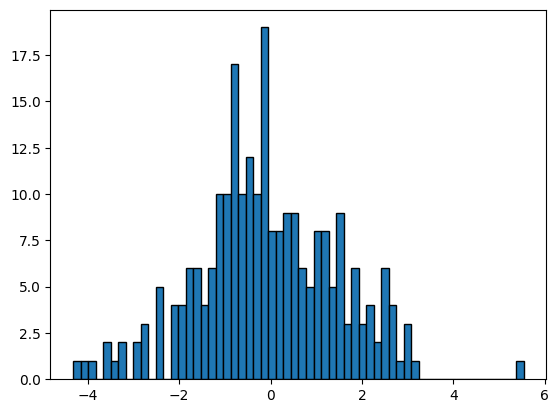

In [11]:
plt.hist(list(gf['% update ^GSPC'].values), bins=60, edgecolor='black')

(array([ 2.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  8.,  1.,  3.,  4.,  3.,
         7.,  4.,  9., 11., 10.,  6., 11.,  8.,  9., 10., 20., 14., 11.,
         9.,  9.,  5.,  9.,  9.,  6.,  7.,  7.,  7.,  3.,  2.,  4.,  1.,
         2.,  3.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-5.86795239, -5.62186223, -5.37577207, -5.12968191, -4.88359176,
        -4.6375016 , -4.39141144, -4.14532128, -3.89923112, -3.65314096,
        -3.4070508 , -3.16096064, -2.91487049, -2.66878033, -2.42269017,
        -2.17660001, -1.93050985, -1.68441969, -1.43832953, -1.19223937,
        -0.94614922, -0.70005906, -0.4539689 , -0.20787874,  0.03821142,
         0.28430158,  0.53039174,  0.77648189,  1.02257205,  1.26866221,
         1.51475237,  1.76084253,  2.00693269,  2.25302285,  2.49911301,
         2.74520316,  2.99129332,  3.23738348,  3.48347364,  3.7295638 ,
         3.97565396,  4.22174412,  4.46783428,  4.71392443,  4.96001459,
 

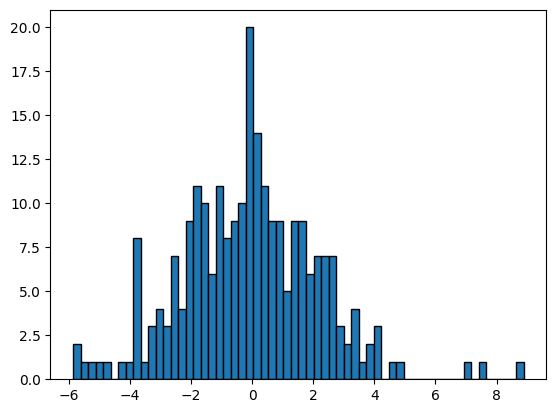

In [13]:
plt.hist(list(gf[f'% update {st}'].values), bins=60, edgecolor='black')

математическое ожидание

In [ ]:
# %time snp_mat_expectation = gf['% update ^GSPC'].sum() / gf['% update ^GSPC'].value_counts().sum()
# %time snp_mat_expectation = np.average(gf['% update ^GSPC'])
snp_mat_expectation = gf['% update ^GSPC'].mean()
snp_mat_expectation

стандартное отклонение

In [ ]:
snp_standart_deviation = gf['% update ^GSPC'].std()
snp_standart_deviation

In [ ]:
snp_standart_deviation = gf[f'% update {st}'].std()
snp_standart_deviation

In [ ]:
mu_z = gf['% update ^GSPC'].mean()
# se_z = gf['% update ^GSPC'].std() / sqrt(gf['% update ^GSPC'].value_counts().sum())
se_z = gf['% update ^GSPC'].std() 
z_values_snp = [(x - mu_z) / se_z for x in gf['% update ^GSPC']]

z_values_snp[:5]